# Decision Trees and Forests exercise

Today we are going to apply different Random Tree algorithms to the dataset from the AA1 competition. Note that the dataset has been modified: 4 outliers have been removed and I have transformed the variables with some BoxCox transformations. So I will simply apply a Standard Scaler to my variables.

We are going to do the split over the training dataset, treating it as a whole dataset.

We will use the F1-Macro as the metric to evaluate in our models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.precision', 3)

In [2]:
# Extra imports
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz

from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB

from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(42)  # The solution.

In [5]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

## 0. Data

In [6]:
data = pd.read_csv("boxcox_ILDS.csv", delimiter = ",", dtype = np.float64)
data.head()

,Unnamed: 0,Age,Female,TP,ALB,AR,target,DBratio,TB,DB,Alkphos,Sgpt,Sgot
0,0.0,48.0,0.0,7.0,2.4,0.52,0.0,0.511,0.920,0.721,1.300,1.475,1.945
1,1.0,39.0,0.0,7.4,4.3,1.38,0.0,0.474,0.514,-0.107,1.293,1.736,1.917
2,2.0,23.0,0.0,6.2,3.1,1.00,0.0,0.300,0.000,-1.503,1.296,1.732,1.957
3,3.0,42.0,1.0,6.2,3.2,1.06,0.0,0.286,-0.407,-2.172,1.290,1.705,1.959
4,4.0,52.0,1.0,6.9,3.3,0.90,1.0,0.167,-0.617,-3.566,1.294,1.393,1.519


In [7]:
data = data.drop(columns = ["Unnamed: 0"])
data.describe()

,Age,Female,TP,ALB,AR,target,DBratio,TB,DB,Alkphos,Sgpt,Sgot
count,457.000,457.000,457.000,457.000,457.000,457.000,457.000,457.000,457.000,457.000,457.000,457.000
mean,45.035,0.241,6.425,3.109,0.942,0.289,0.347,0.172,-1.121,1.297,1.705,1.846
std,16.293,0.428,1.051,0.794,0.318,0.454,0.128,0.591,1.517,0.007,0.123,0.150
min,4.000,0.000,2.700,0.900,0.300,0.000,0.048,-1.297,-3.566,1.269,1.393,1.489
25%,33.000,0.000,5.700,2.500,0.700,0.000,0.250,-0.242,-2.172,1.293,1.620,1.732
50%,45.000,0.000,6.500,3.100,0.900,0.000,0.308,0.000,-1.503,1.296,1.699,1.841
75%,58.000,0.000,7.100,3.700,1.100,1.000,0.462,0.691,0.177,1.301,1.788,1.957
max,90.000,1.000,9.500,5.500,2.800,1.000,0.727,1.329,1.812,1.314,2.002,2.176


In [8]:
X = data.drop(columns = ["target"])
y = data['target']

def preprocessing (X, y, scaler = None):
    if scaler == None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    return X, np.array(y), scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, y_train, scaler = preprocessing(X_train, y_train)
X_test, y_test, _ = preprocessing(X_test, y_test, scaler)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(type(X_train), type(y_train))

(292, 11) (292,) (92, 11) (92,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 1. Simple Decision Tree



In [9]:
model_tree = DecisionTreeClassifier(class_weight='balanced').fit(X_train, y_train)

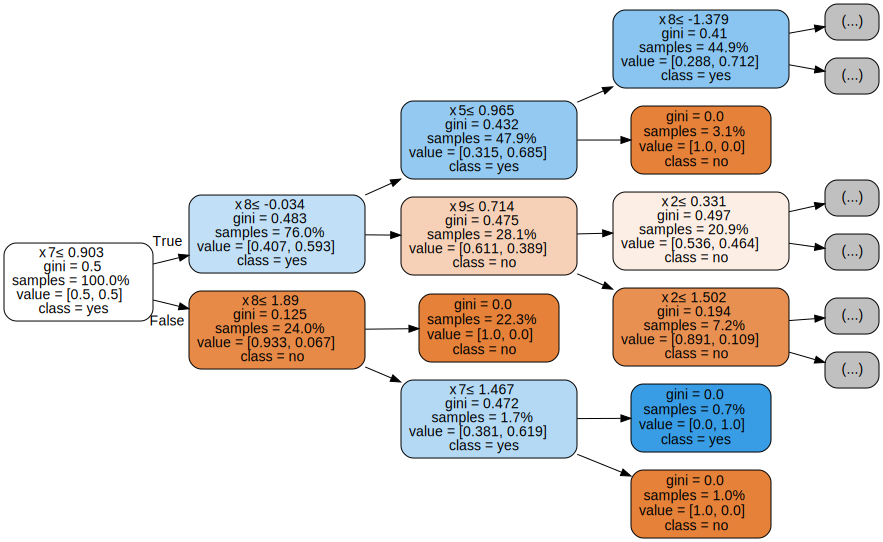

In [10]:
dot_data = export_graphviz(model_tree, out_file=None,  
                           class_names=['no', 'yes'],  
                           filled=True, rounded=True,  
                           special_characters=True, 
                           rotate=True,
                           proportion=True,
                           max_depth=3)  
graph = graphviz.Source(dot_data)  
graph 

In [11]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion_matrix(y_val, y_pred)

array([[33, 16],
       [16,  8]])

In [12]:
print(classification_report(y_val, y_pred))

results

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        49
         1.0       0.33      0.33      0.33        24

    accuracy                           0.56        73
   macro avg       0.50      0.50      0.50        73
weighted avg       0.56      0.56      0.56        73



,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.562,0.333,0.673,0.503


In [13]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 14
Nodes: 127


In [14]:
criterion = ['gini', 'entropy']

max_dephts = [None, 2, 4, 6, 8, 10]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier(class_weight = 'balanced')

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:18.090537


In [15]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
649,entropy,None,sqrt,5,5,0.665,0.774,0.556,0.702
1052,entropy,8,log2,1,3,0.658,0.751,0.566,0.685
1069,entropy,8,log2,4,5,0.648,0.735,0.560,0.671
47,gini,None,sqrt,5,3,0.647,0.756,0.538,0.681
632,entropy,None,sqrt,2,3,0.646,0.772,0.519,0.692


In [16]:
best_params_dt = model_5CV.best_params_
best_params_dt

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5}

In [17]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion_matrix(y_val,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


## 2. Random Forests

In [18]:
model_rf1 = RandomForestClassifier(class_weight = 'balanced', oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion_matrix(y_train,pred)

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       207
         yes       1.00      1.00      1.00        85

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

OOB accuracy= 0.726027397260274


In [19]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion_matrix(y_val,y_pred)

Validation Accuracy:0.6986301369863014


array([[42,  7],
       [15,  9]])

In [20]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.699,0.45,0.792,0.621
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


In [21]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:04.449826


In [22]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
38,100,6,6,0.682,0.779,0.585,0.712
30,None,6,6,0.681,0.774,0.588,0.709
44,None,6,4,0.680,0.775,0.584,0.709
36,100,6,4,0.673,0.768,0.579,0.702
20,100,6,4,0.672,0.770,0.574,0.702


In [23]:
best_params_rf = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params_rf

{'class_weight': 'balanced_subsample',
 'max_depth': 100,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 200}

In [24]:
rf_model_tuned = RandomForestClassifier(**best_params_rf)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.671,0.538,0.745,0.642
RF-default,0.699,0.45,0.792,0.621
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


In [25]:
confusion_matrix(y_val, y_pred)

array([[35, 14],
       [10, 14]])

## 3. Extra trees

In [26]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.671,0.538,0.745,0.642
RF-default,0.699,0.45,0.792,0.621
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


In [27]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:01.785551


In [28]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
24,None,2,4,0.669,0.788,0.549,0.712
42,None,2,6,0.668,0.773,0.563,0.702
32,100,2,4,0.665,0.784,0.547,0.709
26,None,2,6,0.662,0.777,0.546,0.702
18,100,2,6,0.661,0.778,0.543,0.702


In [29]:
best_params_et = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params_et

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [30]:
extra_trees_best = ExtraTreesClassifier(**best_params_et)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
extra_trees-best,0.712,0.571,0.784,0.677
RF-best,0.671,0.538,0.745,0.642
RF-default,0.699,0.45,0.792,0.621
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


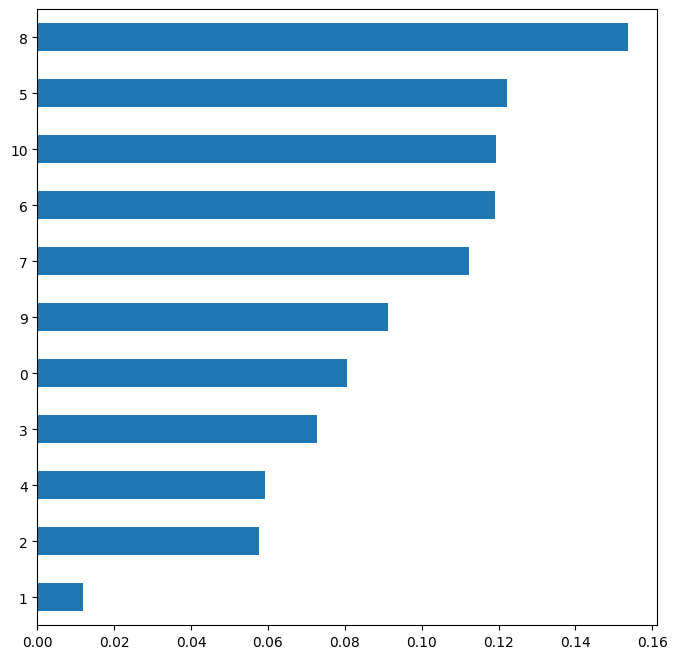

In [31]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_})

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

In [32]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

y_pred = gauss_nb.predict(X_val)

results.loc['GaussianNB-default',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
extra_trees-best,0.712,0.571,0.784,0.677
RF-best,0.671,0.538,0.745,0.642
RF-default,0.699,0.45,0.792,0.621
GaussianNB-default,0.562,0.529,0.59,0.56
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


In [33]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

y_pred = gauss_nb.predict(X_val)

results.loc['GaussianNB-default',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
extra_trees-best,0.712,0.571,0.784,0.677
RF-best,0.671,0.538,0.745,0.642
RF-default,0.699,0.45,0.792,0.621
GaussianNB-default,0.562,0.529,0.59,0.56
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503
DT-best,0.507,0.455,0.55,0.502


In [34]:
model_tree_best = DecisionTreeClassifier(class_weight = 'balanced', **best_params_dt)
model_rf_best = RandomForestClassifier(**best_params_rf)
extra_trees_best = ExtraTreesClassifier(**best_params_et)
gauss_nb = GaussianNB()

voting_hard = VotingClassifier([('dt', model_tree_best), ('rf', model_rf_best),
                                ('gnb', gauss_nb), ('extratrees', extra_trees_best)])
voting_hard.fit(X_train, y_train)

y_pred = voting_hard.predict(X_val)

results.loc['voting_hard', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard'],:].sort_values(
    by='F1-score (macro avg)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.699,0.45,0.792,0.621
voting_hard,0.644,0.5,0.723,0.612
GaussianNB-default,0.562,0.529,0.59,0.56
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503


In [35]:
voting_soft = VotingClassifier([('dt', model_tree_best), ('rf', model_rf_best),
                                ('gnb', gauss_nb),('extratrees', extra_trees_best)],voting='soft')
voting_soft.fit(X_train, y_train)

y_pred = voting_soft.predict(X_val)

results.loc['voting_soft', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard','voting_soft'],:].sort_values(
    by='F1-score (macro avg)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.699,0.45,0.792,0.621
voting_hard,0.644,0.5,0.723,0.612
voting_soft,0.603,0.508,0.667,0.588
GaussianNB-default,0.562,0.529,0.59,0.56
extra_trees,0.671,0.333,0.782,0.558
DT-default,0.562,0.333,0.673,0.503


In [36]:
stacky = StackingClassifier(
    estimators=[('rf', model_rf_best), ('extratrees', extra_trees_best)],
    final_estimator=GradientBoostingClassifier())

stacky.fit(X_train, y_train)

y_pred = stacky.predict(X_val)

results.loc['stackyn-clf', :] = compute_metrics(y_val, y_pred)
results.loc[['RF-best','extra_trees-best','stackyn-clf'],:].sort_values(by='F1-score (class 1)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
extra_trees-best,0.712,0.571,0.784,0.677
RF-best,0.671,0.538,0.745,0.642
stackyn-clf,0.699,0.353,0.804,0.578


## Final evaluation

We choose to use the best extra trees model we have.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, y_train, scaler = preprocessing(X_train, y_train)
X_test, y_test, _ = preprocessing(X_test, y_test, scaler)

extra_trees_best.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76        69
         1.0       0.32      0.35      0.33        23

    accuracy                           0.65        92
   macro avg       0.55      0.55      0.55        92
weighted avg       0.66      0.65      0.66        92



In [40]:
confusion_matrix(y_test, y_pred)

array([[52, 17],
       [15,  8]])